In [1]:
import rioxarray
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs


In [2]:
ds = xr.tutorial.open_dataset('rasm') # use xr.tutorial.load_dataset() for xarray<v0.11.0
ds = ds.rename({'xc': 'lon', 'yc': 'lat'})
ds = ds.rename_vars({'Tair':'temperature'})
spatial_coords = ['lon', 'lat']
for c, coef in zip(spatial_coords, [180, 360]):

    ds.coords[c] = (ds.coords[c] + coef) % (coef*2) - coef
    
ds = ds.transpose(*[x for x in  ds.dims if x not in ds.coords.keys()], ...)

ds = ds.sortby(['x', 'y'])

ds['temp2'] = ds['temperature'] + 273.24

ds

<xarray.Dataset>
Dimensions:      (time: 36, x: 275, y: 205)
Coordinates:
  * time         (time) object 1980-09-16 12:00:00 ... 1983-08-17 00:00:00
    lon          (x, y) float64 -170.8 -171.0 -171.3 ... 16.34 16.63 16.91
    lat          (x, y) float64 16.53 16.69 16.85 17.01 ... 27.94 27.73 27.51
Dimensions without coordinates: x, y
Data variables:
    temperature  (x, y, time) float64 ...
    temp2        (x, y, time) float64 nan nan nan nan ... 301.0 300.5 301.4
Attributes:
    title:                     /workspace/jhamman/processed/R1002RBRxaaa01a/l...
    institution:               U.W.
    source:                    RACM R1002RBRxaaa01a
    output_frequency:          daily
    output_mode:               averaged
    convention:                CF-1.4
    references:                Based on the initial model of Liang et al., 19...
    comment:                   Output from the Variable Infiltration Capacity...
    nco_openmp_thread_number:  1
    NCO:                       "4.6.0"
    history:                   Tue Dec 27 14:15:22 2016: ncatted -a dimension...

In [25]:

def prepare_xdata(ds, spatial_coords=['lon', 'lat']):
    
    for c, coef in zip(spatial_coords, [180, 360]):

        ds.coords[c] = (ds.coords[c] + coef) % (coef*2) - coef

    dims = list(ds.dims)
    ds = ds.sortby(list(ds.dims))
    
    return ds


def get_min_max_coords(coords):
    
    return np.array([coords.min(), coords.max()])

def regrid(xres, yres, data_array, xcoord='lon', ycoord='lat'):
    
    xmin, xmax = get_min_max_coords(data_array.coords[xcoord])
    ymin, ymax = get_min_max_coords(data_array.coords[ycoord])
    
    xbins = np.arange(xmin-xres/2, xmax + xres/2, xres)
    ybins = np.arange(ymin - ymin/2, ymax + ymin/2, yres)
    
    y = data_array.coords['lat'].values.ravel()
    x = data_array.coords['lon'].values.ravel()
    # Bin the data onto a 10x10 grid
    # Have to reverse x & y due to row-first indexing
    zi, yi, xi = np.histogram2d(x, y, bins=[xbins,ybins], weights=data_array.values.flatten(), normed=False)
    counts, _, _ = np.histogram2d(x, y, bins=[xbins,ybins])
    
    counts = np.where(np.isclose(counts, np.array([0])), np.nan, counts)
    zi = np.where(np.isclose(zi, np.array([0])), np.nan, zi)
    
    zi = zi / counts
    #zi = np.ma.masked_invalid(zi)
    
    yshape = yi.size -1
    xshape = xi.size -1
    
    return xr.DataArray(zi.reshape( (yshape,
                                     xshape
                                    )), 
                        
                        coords={'lon':yi[:-1],
                                'lat':xi[:-1]}, 
                        
                        dims=['lon', 'lat'],
                       name=data_array.name)

def interpolate_temporal_dataset(ds, xres, yres , spatial_coords=['lon', 'lat'], time_dim='time'):

    ds = prepare_xdata(ds, spatial_coords=spatial_coords)

    interp_dataArrays = []

    for i in ds.data_vars:
        
        das = []


        for idx, group in ds[i].groupby(time_dim):


            da = regrid(xres=xres, yres=yres, data_array=group)
            da = da.assign_coords({time_dim:idx})

            das.append(da)


        interp_dataArray = xr.concat(das, dim=time_dim)
        
        interp_dataArrays.append(interp_dataArray)
        
    interp_dataSet = xr.merge(interp_dataArrays)


    return interp_dataSet

def interpolate_non_temporal_dataset(ds, xres, yres , spatial_coords=['lon', 'lat']):
    
    ds = prepare_xdata(ds, spatial_coords=spatial_coords)
    
    das = []
    for i in ds.data_vars:
        
        
        da = ds[i]
        da = regrid(xres=xres, yres=yres, data_array=da)

        das.append(da)


        
    interp_dataSet_non_temporal = xr.merge(das)

    
    return interp_dataSet_non_temporal




if '__main__' == __name__:

    interp_dataSet = interpolate_temporal_dataset(ds, xres=5, yres=5 , spatial_coords=['lon', 'lat'], time_dim='time')

C:\Anaconda3\envs\Python_3.8\lib\site-packages\matplotlib\figure.py:456: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  warnings.warn(


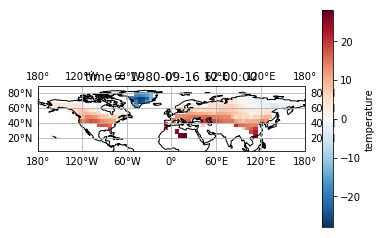

In [4]:
    
fig, ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()})
interp_dataSet['temperature'].isel(time=0).plot(x='lon', y='lat', ax=ax)
ax.coastlines()
ax.gridlines(draw_labels=True)
fig.show()

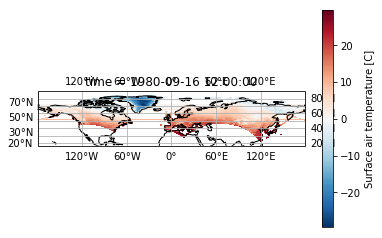

In [5]:
    
fig, ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()})
ds['temperature'].isel(time=0).plot(x='lon', y='lat', ax=ax)
ax.coastlines()
ax.gridlines(draw_labels=True)
fig.show()

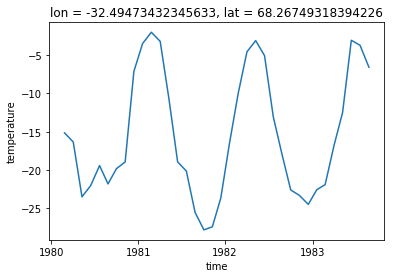

In [6]:
interp_dataSet.sel({'lon':-30, 'lat':70}, method='nearest')['temperature'].plot()

In [61]:

def dataArray_to_tiff(da, lon_name='lon', lat_name='lat', crs="epsg:4326", pathname='test.tif'):


    da = da.rio.set_spatial_dims(lon_name, lat_name, False).rio.write_crs(crs)
    
    
    if len(interp_dataSet_Tmean.to_array().dims)==3:
    
        transposing_order = [x for x in da.dims if x not in [lon_name, lat_name]]
        transposing_order = transposing_order +[lat_name, lon_name]
        
    elif len(interp_dataSet_Tmean.to_array().dims) == 2:
        transposing_order = [lat_name, lon_name]
    
    else:
        raise('Dimensions must be at most 3, and not below 2')
    
    da = da.transpose(*transposing_order).rio.set_spatial_dims(lon_name, lat_name, False).rio.to_raster(pathname)
    

In [63]:
dataArray_to_tiff(interp_dataSet.mean('time').to_array())